In [3]:
## over-parametrized setting

import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import math


In [4]:
# Set random seed for reproducibility.
#np.random.seed(13)

######################################
# Helper Functions 
######################################
def clip_C(val, C):
    return np.clip(val, -C, C)

def project_matrix(M, radius, dp_enabled=True):
    if dp_enabled:
        fro_norm = np.linalg.norm(M, 'fro')
        if fro_norm > radius:
            return (radius / fro_norm) * M
        return M
    else:
        return M

def sample_unit_sphere(d):
    x = np.random.randn(d)
    return x / np.linalg.norm(x)

def sample_L_unit_sphere(d, L):
    X = np.random.randn(L, d)
    X_norms = np.linalg.norm(X, axis=1, keepdims=True)
    return X / X_norms

def compute_Ztilde(x_query, xs, ys, L, G, C, dp_enabled=True):
    """
    Compute the summary statistic Z_tilde for a query point.

    Z_tilde = Pi_G((1/L) * outer(x_query, sum_i clip_C(ys[i]) * xs[i]))

    Parameters:
        x_query (np.ndarray): Query vector of shape (D,).
        xs (np.ndarray): Data vectors of shape (L, D).
        ys (np.ndarray): Labels of shape (L,).
        L (int): Number of samples.
        G (float): Frobenius norm clipping threshold.
        C (float): Label clipping threshold.
        dp_enabled (bool): Whether to apply clipping and projection.

    Returns:
        np.ndarray: Projected matrix Z_tilde of shape (D, D).
    """
    ys_clipped = np.clip(ys, -C, C) if dp_enabled else ys
    v = np.sum(ys_clipped[:, None] * xs, axis=0)
    Z = (1.0 / L) * np.outer(x_query, v)
    return project_matrix(Z, G, dp_enabled)


def compute_Ztilde_vectorized(xq, xs, ys, L, G, C, dp_enabled=True):
    """
    Vectorized computation of the summary statistic for a batch of prompts.
      xq: shape (N, D)
      xs: shape (N, L, D)
      ys: shape (N, L)
    Returns:
      Z: shape (N, D, D)
    """
    if dp_enabled:
        ys_clipped = np.clip(ys, -C, C)
    else:
        ys_clipped = ys
    # Compute v for each prompt: shape (N, D)
    v = np.sum(ys_clipped[..., None] * xs, axis=1)
    # Compute outer product for each prompt: shape (N, D, D)
    Z = (1.0 / L) * (xq[:, :, None] * v[:, None, :])
    if dp_enabled:
        fro_norm = np.linalg.norm(Z, axis=(1,2))
        scaling = np.where(fro_norm > G, G / fro_norm, 1.0)
        Z = Z * scaling[:, None, None]
    return Z



def dp_noise(shape, noise_std):
    return np.random.normal(0, noise_std, size=shape)

def generate_prompt(D, L):
    xs = sample_L_unit_sphere(D, L)
    x_query = sample_unit_sphere(D)
    w_true = np.random.randn(D)
    ys = xs @ w_true
    y_query = x_query @ w_true
    return xs, x_query, ys, y_query

def build_dataset(N, D, L):
    xs_all, xq_all, ys_all, yq_all = [], [], [], []
    for _ in range(N):
        xs, xq, ys, yq = generate_prompt(D, L)
        xs_all.append(xs)
        xq_all.append(xq)
        ys_all.append(ys)
        yq_all.append(yq)
    return np.array(xs_all), np.array(xq_all), np.array(ys_all), np.array(yq_all)



In [5]:
def train_algorithm2(xs_all, xq_all, ys_all, yq_all,
                     D, N, L,
                     C, R, G, lam, eta0, T, epsilon, delta,
                     sigma_multiplier, dp_enabled):
    """
    Trains "Algorithm 2" from the paper.

    Parameters:
        xs_all, xq_all, ys_all, yq_all: dataset tensors
        D (int): Dimensionality
        N (int): Number of prompts
        L (int): Number of training tokens per prompt
        C, R, G, lam, eta0: model hyperparameters
        T (int): Number of training steps
        epsilon, delta: DP parameters
        sigma_multiplier (float): scales DP noise
        dp_enabled (bool): whether DP is active

    Returns:
        train_losses (list): MSE per iteration
        Gamma (np.ndarray): final (D, D) matrix
        Ztilde_ls (np.ndarray): summary matrices (N, D, D)
        noise_std (float): DP noise standard deviation
    """

    # Precompute Z_tilde matrices
    Ztilde_ls = np.array([
        compute_Ztilde(xq_all[k], xs_all[k], ys_all[k], L, G, C, dp_enabled)
        for k in range(N)
    ])  # shape (N, D, D)

    # Differential Privacy noise scale
    if dp_enabled:
        sigma_lower_bound = 2.0 * G * (C + R * G)
        sigma = sigma_lower_bound * sigma_multiplier
        denom = (epsilon**2) * (N**2)
        noise_variance = (2.0 * (eta0**2) * (T**2) * (sigma**2) * np.log(1.25 * T / delta)) / denom
        noise_std = np.sqrt(noise_variance)
    else:
        noise_std = 0.0

    # Initialize Gamma
    Gamma = np.random.randn(D, D) * 0.1
    Gamma = project_matrix(Gamma, R, dp_enabled)

    train_losses = []

    for t in range(T):
        # Predict y for each prompt
        y_preds = np.einsum('nij,ij->n', Ztilde_ls, Gamma)  # shape (N,)
        y_clips = np.clip(yq_all, -C, C) if dp_enabled else yq_all
        errs = y_preds - y_clips

        # Gradient update
        grad_sum = np.einsum('n,nij->ij', errs, Ztilde_ls) / N
        grad_mat = grad_sum + 2.0 * lam * Gamma

        # DP noise
        noise = dp_noise(Gamma.shape, noise_std)

        # Update Gamma
        Gamma = Gamma - eta0 * grad_mat + noise
        Gamma = project_matrix(Gamma, R, dp_enabled)

        # MSE loss
        mse_avg = np.mean((y_preds - yq_all) ** 2)
        train_losses.append(mse_avg)

    return train_losses, Gamma, Ztilde_ls, noise_std


In [6]:
######################################
# Experiment Setup
######################################
# Global parameters.
epsilon_lst = [ 0.2, 0.4, 0.6, 0.8, 1]
delta = 1e-5
sigma_multiplier = 1
N_lst = [1000, 1500, 2000, 2500, 3000, 3500, 4000]

In [7]:
def run_experiment(N, epsilon, n_simulations=500):
    """
    For a single N and epsilon, run the entire training and evaluation
    n_simulations times and average the excess risks.

    Returns:
      - avg_excess_risk_no_dp: average excess risk (non-DP) over n_simulations
      - avg_excess_risk_dp: average excess risk (DP) over n_simulations
    """

    D = 5
    L = int(N ** 0.5)
    lam = 5
    C = np.sqrt(2 * np.log(N * L))
    R = (1 / lam) * (C ** 2) * np.sqrt(N / L)
    G = (C / np.sqrt(L)) * (1 + (np.log(N) / (D ** 2)) ** (1 / 4))
    eta0 = 0.95 * (2 * lam / (3 * ((lam + G ** 2) ** 2)))
    T = int(2.5 * (np.log(N)) / np.log(1 / (1 - eta0 * lam)))

    N_test = 500

    excess_risks_no_dp = []
    excess_risks_dp = []

    for _ in tqdm(range(n_simulations), desc="Running simulations"):
        # Build training and test datasets
        xs_train, xq_train, ys_train, yq_train = build_dataset(N, D, L)
        xs_test, xq_test, ys_test, yq_test = build_dataset(N_test, D, L)

        # Train non-DP Algorithm 2
        losses_no_dp, Gamma_no_dp, Ztilde_ls, _ = train_algorithm2(
            xs_train, xq_train, ys_train, yq_train,
            D, N, L,
            C, R, G, lam, eta0, T,
            epsilon, delta,
            sigma_multiplier, dp_enabled=False
        )

        # Compute ridge oracle from non-DP training statistics
        d1, d2 = Ztilde_ls.shape[1:3]
        D_total = d1 * d2
        Zmat = Ztilde_ls.reshape(N, D_total)
        A = (N * lam) * np.eye(D_total) + Zmat.T @ Zmat
        b = Zmat.T @ yq_train
        L_chol = np.linalg.cholesky(A)
        v = np.linalg.solve(L_chol, b)
        gamma_vec = np.linalg.solve(L_chol.T, v)
        Gamma_star = gamma_vec.reshape(d1, d2)

        # Compute test predictions (same for all runs)
        Z_test_all = compute_Ztilde_vectorized(xq_test, xs_test, ys_test, L, G, C, dp_enabled=False)
        y_hat_ridge = np.sum(Gamma_star * Z_test_all, axis=(1, 2))

        # Non-DP predictions
        y_hat_no_dp = np.sum(Gamma_no_dp * Z_test_all, axis=(1, 2))
        mse_no_dp = np.mean((y_hat_no_dp - y_hat_ridge) ** 2)
        excess_risks_no_dp.append(mse_no_dp)

        # Train DP Algorithm 2
        losses_dp, Gamma_dp, _, _ = train_algorithm2(
            xs_train, xq_train, ys_train, yq_train,
            D, N, L,
            C, R, G, lam, eta0, T,
            epsilon, delta,
            sigma_multiplier, dp_enabled=True
        )

        y_hat_dp = np.sum(Gamma_dp * Z_test_all, axis=(1, 2))
        mse_dp = np.mean((y_hat_dp - y_hat_ridge) ** 2)
        excess_risks_dp.append(mse_dp)
        
        
    
    # Average excess risks across simulations
    avg_excess_risk_no_dp = np.mean(excess_risks_no_dp)
    avg_excess_risk_dp = np.mean(excess_risks_dp)

    return avg_excess_risk_no_dp, avg_excess_risk_dp


In [8]:
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
import itertools
import numpy as np

np.random.seed(1609)

# Config
epsilon_lst = [0.2, 0.4, 0.6, 0.8, 1]
N_lst = [1000, 1500, 2000, 2500, 3000, 3500, 4000]
delta = 1e-5
sigma_multiplier = 1
n_simulations = 500

# Wrapper to return results as (N, epsilon): (no_dp, dp)
def run_experiment_wrapper(N, epsilon):
    return (N, epsilon), run_experiment(N, epsilon, n_simulations)

# Create all combinations of parameters
param_grid = list(itertools.product(N_lst, epsilon_lst))

# Run in parallel using 4 cores
with tqdm_joblib(tqdm(desc="Running experiments", total=len(param_grid), ncols=100, position=0)) as progress_bar:
    results = Parallel(n_jobs=4)(
        delayed(run_experiment_wrapper)(N, eps) for N, eps in param_grid
    )

# Collect into a dictionary
results_dict = dict(results)


/Users/kingsleyyeon/opt/anaconda3/lib/python3.8/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Running experiments:   0%|                                                   | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

In [10]:
import pandas as pd

# Convert to CSV
rows = []
for (N, eps), (no_dp, dp) in results_dict.items():
    rows.append({"N": N, "epsilon": eps, "no_dp": no_dp, "dp": dp})
df_results = pd.DataFrame(rows)
df_results.to_csv("dp_excess_risk_results.csv", index=False)

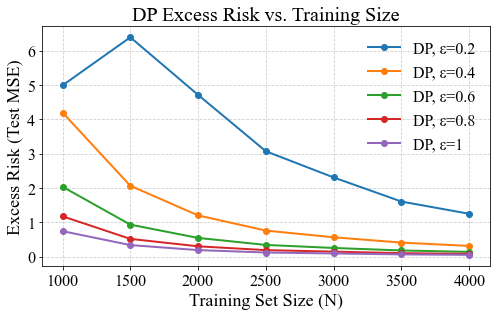

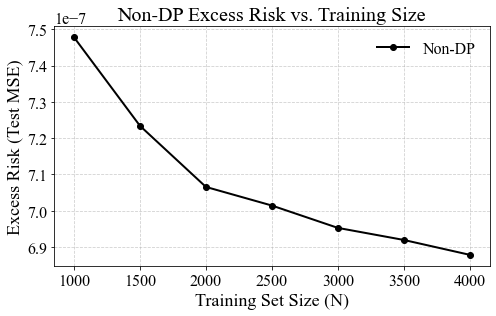

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# === Matplotlib config ===
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "DejaVu Serif"],
    "axes.titlesize": 18,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "lines.linewidth": 2,
    "lines.markersize": 6,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.6
})

# === Reorganize results for plotting ===
errors = {eps: {"dp": [], "no_dp": []} for eps in epsilon_lst}
N_lst_sorted = sorted(N_lst)
for eps in epsilon_lst:
    for N in N_lst_sorted:
        no_dp, dp = results_dict[(N, eps)]
        errors[eps]["dp"].append(dp)
        errors[eps]["no_dp"].append(no_dp)

# === DP Excess Risk Plot ===
plt.figure(figsize=(7, 4.5))
for eps in epsilon_lst:
    plt.plot(
        N_lst_sorted,
        errors[eps]["dp"],
        marker='o',
        label=f"DP, ε={eps}"
    )
plt.xlabel("Training Set Size (N)")
plt.ylabel("Excess Risk (Test MSE)")
plt.title("DP Excess Risk vs. Training Size", fontsize=20)
plt.legend(loc="upper right", frameon=False)
plt.tight_layout()
plt.savefig("dp_excess_risk_vs_N.png", dpi=300)
plt.show()

# === Non-DP Excess Risk Plot ===
plt.figure(figsize=(7, 4.5))
plt.plot(N_lst_sorted, errors[epsilon_lst[0]]["no_dp"], marker='o', color='black', label="Non-DP")
plt.xlabel("Training Set Size (N)")
plt.ylabel("Excess Risk (Test MSE)")
plt.title("Non-DP Excess Risk vs. Training Size", fontsize=20)
plt.legend(loc="upper right", frameon=False)
plt.tight_layout()
plt.savefig("non_dp_excess_risk_vs_N.png", dpi=300)
plt.show()
